In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import kmedoids
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
def create_comparation_table_clustering(pred, X, labels, dict_class_types, class_label):
    ''' Create a dataframe with the values of all the features (denoted by X) and the label results
    of the clustering algorithm, plus class names (table denoted by yhat). Also, returns a comparision table
    with the presence of each class type with each cluster type, if present.
    
    Args:
        - pred (pd.DataFrame): class prediction result.
        - X (pd.DataFrame): features dataset, input for prediction.
        - labels (pd.Series): true labels of the original dataset.
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name).
        
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model.
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        
        
    '''    
    
    # Create dataframe with features plus prediction values
    yhat = X.copy()
    yhat['cluster_label'] = pred
    yhat['class_label'] = labels
    yhat['class_name'] = yhat['class_label'].replace(dict_class_types)
    
    # Create comparision table with results
    check_labels_w_names = yhat.groupby(['class_label','cluster_label']).size().reset_index()
    check_labels_w_names['class_name'] = check_labels_w_names['class_label'].replace(dict_class_types)
    check_labels_w_names = check_labels_w_names.set_index(['class_name', 'class_label'])
    check_labels_w_names = pd.merge(check_labels_w_names.reset_index(), class_label[['Class_Number', 'Number_Of_Animal_Species_In_Class']], 
            'left', left_on = 'class_label', right_on = 'Class_Number')
    check_labels_w_names = check_labels_w_names.rename({'Number_Of_Animal_Species_In_Class': 'class_total_number',
                                                        0: 'cluster_total_number'}, axis = 1)
    check_labels_w_names['presence_relative_to_class'] = np.round(check_labels_w_names['cluster_total_number']/check_labels_w_names['class_total_number'],3)
    comp_table = check_labels_w_names.set_index(['class_name', 'class_label'])

    return yhat, comp_table

In [4]:
def compute_distance_matrix(centroids_clusters, centroids_classes):
    """ 
    Calculation of the distance between two vectors.
    
    Args:
        - centroids_clusters (pd.DataFrame): matrix of the centroids for each cluster.
        - centroids_classes (pd.DataFrame): matrix of the centroids for each of the classes.
        
    Returns:
        - dmatrix (pd.DataFrame): distance matrix between centroids of each cluster with each class.
    
    """
    

    distance_matrix = []
    for cluster in centroids_clusters.index:
        distance_cluster_list = []
        for class_centroid in centroids_classes.index:
            eu_distance = np.linalg.norm(centroids_clusters.loc[cluster] - centroids_classes.loc[class_centroid])
            distance_cluster_list.append(eu_distance)
        distance_matrix.append(distance_cluster_list)
        
    dmatrix = pd.DataFrame(distance_matrix, 
                           index = list(centroids_clusters.index),
                           columns = list(centroids_classes.index))
    
    return dmatrix

In [5]:
def assign_clusters_distance(dmatrix):
    
    """
    Assign based on Euclidean distance between centroids the most similar cluster
    
    Args:
        - dmatrix (pd.DataFrame): dataframe with cluster numbers as indexes and class labels as columns. Values are the distances
                                previously computed.
    
    Returns:
        - cluster_assignment (pd.Series):  assignment of each cluster for each class label.
    
    """

    cluster_assignment = dmatrix.idxmin()
    # print(len(dmatrix.columns))
    if len(cluster_assignment.unique()) != len(dmatrix.columns):
        print('There are repeated assignments for one or several classes!!!')
        
    # todo: create alg for assign based on most near centroid
    
    return cluster_assignment
    
    

In [6]:
def classification_metrics(yhat, centroids_clusters,assignment):
    """
    Computation of the a regular classification model based on a confusion matrix
    
    Args:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model.
        - assignment (dict): dictionary with the cluster number (keys) and their corresponding true class name (values). 
    
    Returns:
        - metrics_result_df (pd.DataFrame): result table with metrics.
    
    """
    
    cc = centroids_clusters.copy()
    metrics_result_df = pd.DataFrame(columns = ["class_name","Accuracy", "Precision", "Specificity", "Recall", "F1"])
    
    for cluster_number, class_name in assignment.items():
        predicted_bool_col = yhat["cluster_label"] == cluster_number
        true_bool_col = yhat["class_name"] == class_name
        acc_sc = accuracy_score(true_bool_col, predicted_bool_col)
        pre_sc = precision_score(true_bool_col, predicted_bool_col)
        specificity_sc = recall_score(true_bool_col, predicted_bool_col, pos_label = 0)
        recall_sc = recall_score(true_bool_col, predicted_bool_col)
        f1_sc = f1_score(true_bool_col, predicted_bool_col)
        
        metrics_result_df.loc[cluster_number] = [class_name, acc_sc, pre_sc, specificity_sc, recall_sc, f1_sc]
        
    cc["class"] = cc["label_cluster"].replace(assignment)
    return metrics_result_df, cc 

In [7]:
def assign_clusters_distance(dmatrix):
    
    """
    Assign based on Euclidean distance between centroids the most similar cluster
    
    Args:
        - dmatrix (pd.DataFrame): dataframe with cluster numbers as indexes and class labels as columns. Values are the distances
                                previously computed.
    
    Returns:
        - cluster_assignment (pd.Series):  assignment of each cluster for each class label.
    
    """
    
    dm = dmatrix.copy()
    assign_tuples = []

    while len(dm) > 0:
        
        # We get the class that has the min distance computed
        minimum_distance_class = dm.min().idxmin()
        # Get the cluster index relative to that min value
        min_index = dm[minimum_distance_class].idxmin()

        # Save the tuple (index, class)
        assignment_tuple = (int(min_index), minimum_distance_class)
        assign_tuples.append(assignment_tuple)
        dm = dm.drop(min_index)
        dm = dm.drop(minimum_distance_class, axis = 1)
        
    return dict(assign_tuples)
    

In [8]:
def plot_chars_heatmap(data, title = None):
    """
    Plot features from cluster centroids into a heatmap
    
    Args:
        - data (pd.DataFrame): data with values between 0 and 1 representing the presence of each feature for each class.
        - title (str): title of the graph.
    
    Returns:
        - None (only plots a graph).
    
    """
    
    plt.figure(figsize = (7,7))

    ax = sns.heatmap(data = data, annot = True)
    ax.set_title(title)

    plt.show()

In [9]:
def aggregate_features_cluster_centers(zoo_data, columns, cluster_centers = None, index = None):
    """
    Aggregate features based for each centroid of clusters predicted. This function also applies a specific formatting to the returned dataframe.
    
    Args:
        - zoo_data (pd.DataFrame): original dataset with each row as an animal and columns as features. Values are 1 or 0 (presence or not of feature).
        - columns (pd.DataFrame): columns names of the cluster centroid dataset (features).
        - cluster_centers (list): dataframe with cluster centroids.
        - index (list): index names of the cluster centroids dataset (predicted class names).
    
    Returns:
        - agg_clusters: dataframe with the cluster centroids.
        - centroids_classes: dataframe with the classes centroids.
    
    """
    
    # --- For graphs ---
    agg_clusters = pd.DataFrame(cluster_centers , index = index,columns = columns).astype('float32').reset_index().rename({'index': 'label_cluster'}, axis = 1)
    # --- For computation
    centroids_classes = zoo_data.drop(['class_type', 'animal_name'], axis = 1).groupby(['class_names']).mean()
    
    return agg_clusters, centroids_classes

In [10]:
def create_centroids_clusters(yhat, zm, X, create_centroids = [True, None]):
    """
    Aggregate features based for each centroid of clusters predicted. This function also applies a specific formatting to the returned dataframe.
    
    Args:
        - yhat (pd.DataFrame): result dataframe with predictions and features.
        - zm (pd.DataFrame): original dataset with each row as an animal and columns as features. Values are 1 or 0 (presence or not of feature).
        - X (pd.DataFrame): input dataframe for models with only features.
        - create_centroids (list): list with 2 values. First position checks if we want to create centroids for our clusters (in case a particular model
                                 does not return centroids), and creates it in case of True. If False, the second value should be a list containing
                                 the centroids of our clusters.
    
    Returns:
        - centroids_clusters (pd.DataFrame): dataframe with the cluster centroids.
        - centroids_classes (pd.DataFrame): dataframe with the classes centroids.
    
    """
    
    if create_centroids[0]:
        agg_centroids_clusters = yhat.drop(["class_name"], axis = 1).groupby(["cluster_label"]).mean()[X.columns]
        agg_centroids_clusters = pd.DataFrame(data = np.array(agg_centroids_clusters), 
                    index = list(agg_centroids_clusters.index),
                    columns = agg_centroids_clusters.columns)
        
        centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, 
                                                                            np.array(agg_centroids_clusters),
                                                                            list(agg_centroids_clusters.index))
    else:
        centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, 
                                                                                   X.columns, 
                                                                                   create_centroids[1])
    return centroids_clusters, centroids_classes

In [11]:
def result_pipeline(y_pred, zm, X, labels, dict_class_types, class_label, create_centroids = [True, None]):
    """
    Main pipeline for the results of the clustering model applied. Handles results and returns metrics and useful information.
    
    Args:
        - y_pred (pd.DataFrame): class prediction result.
        - zm (pd.DataFrame): original dataset with each row as an animal and columns as features. Values are 1 or 0 (presence or not of feature).
        - X (pd.DataFrame): features dataset, input for prediction.
        - labels (pd.Series): true labels of the original dataset.
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name).
        - create_centroids (list): list with 2 values. First position checks if we want to create centroids for our clusters (in case a particular model
                                 does not return centroids), and creates it in case of True. If False, the second value should be a list containing
                                 the centroids of our clusters.
    
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model.
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        - dmatrix (pd.DataFrame): distance matrix between centroids of each cluster with each class.
        - gb_clusters (pd.DataFrame): cluster centroid dataframe with asignment of cluster label to true class by proximity.
        - assignment (dict): assignment dict of each cluster label for each true class.
        - assignment_new_label (dict): same as assignment dict but each class is replaced by its name (for instance, 1: Mammal, 2: Reptile...).
        - centroids_clusters (pd.DataFrame): dataframe with the cluster centroids.
    
    """

    # Merges prediction result with features dataframe and create a comparation table
    yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

    # Create centroids (in case a model doesn't compute centroids) for each cluster and true class labels
    centroids_clusters, centroids_classes = create_centroids_clusters(yhat, zm, X, create_centroids)

    dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
    assignment = assign_clusters_distance(dmatrix)

    assignment_new_label = dict(zip(assignment.keys(),[f'{x[0]} ({x[1]})' for x in assignment.items()]))
    gb_clusters = centroids_clusters.drop(["legs", "label_cluster"], axis = 1)
    gb_clusters.index = [assignment_new_label[i] for i in centroids_clusters["label_cluster"]]
    

    return yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters

# Data

In [12]:
zoo = pd.read_csv('../data/zoo.csv')
class_label = pd.read_csv('../data/class.csv')
zm = pd.read_pickle('../data/zoo_mod.pkl')

In [13]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))

# Modeling
- Let's see what we can do with baseline clustering models.
- Then, if needed, we will do more wrangling, feature engineering, PCA or other transformations to the data if the result isn't the best.

## K-Means

- Prepare the data for input in algorithms

In [29]:
labels = zm['class_type']
#X = zm.drop(['animal_name', 'class_type', 'class_names', 'hair', 'predator', 'venomous', 'domestic', 'catsize'], axis = 1).copy()
X = zm.drop(['animal_name', 'class_type', 'class_names'], axis = 1).copy()


In [30]:
# From the project description, we know that we have 7 clusters.

k = 7
kmeans = KMeans(n_clusters = k, random_state=42)
y_pred = kmeans.fit_predict(X)

- We have the centroids

In [31]:
kmeans.cluster_centers_[0]

array([ 9.09090909e-02,  9.09090909e-01,  9.09090909e-01,  9.09090909e-02,
        8.18181818e-01,  4.54545455e-02,  4.09090909e-01,  9.09090909e-02,
        1.00000000e+00,  1.00000000e+00, -2.77555756e-17, -5.55111512e-17,
        2.00000000e+00,  1.00000000e+00,  1.36363636e-01,  2.72727273e-01,
        1.36363636e-01])

In [32]:
yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters = result_pipeline(y_pred,
                                                                                           zm,
                                                                                           X, 
                                                                                           labels, 
                                                                                           dict_class_types, 
                                                                                           class_label, create_centroids=[False, kmeans.cluster_centers_])

- For the first run, we have pretty good results. Our model could clusterize correctly the Bird, Fish and Amphibian classes.
- We can see that for mammals, there's also a good presence on cluster label 1 (being 36 of this label), but we still have some missclasified clusters.
- Regarding Reptiles and Invertebrate, we don't have the best result, but we can try doing some other things to increase even more the quality of our model.    

In [33]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     2             1   
             1                        1                    36             1   
             1                        2                     3             1   
Bird         2                        0                    20             2   
Reptile      3                        1                     1             3   
             3                        2                     1             3   
             3                        4                     2             3   
             3                        5                     1             3   
Fish         4                        2                    13             4   
Amphibian    5                        5                     4             5   
Bug          6                        3                     2             6   
             6                        6                     6             6   
Invertebrate 7                        3                     4             7   
             7                        4                     4             7   
             7                        5                     2             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.049  
             1                            41                       0.878  
             1                            41                       0.073  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.200  
             3                             5                       0.200  
             3                             5                       0.400  
             3                             5                       0.200  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       0.250  
             6                             8                       0.750  
Invertebrate 7                            10                       0.400  
             7                            10                       0.400  
             7                            10                       0.200

- We can see that wrongly classified animals of the Mammals class are in fact mammals but have certain features that are more common in other type of classes.

- For example:
    - Dolphins, porpoises and seals -> We can see that all of these animals are mammals, but have features that are more common in the Fish class (they have fins,
            don't have legs, aquatic, majority doesn't have hair)
    - The same happens with the fruitbat and vampires: they are mammals but have features more common to Birds.

In [34]:
zm['animal_name'].loc[(yhat[(yhat['class_name'] == 'Mammal') & (yhat['cluster_label'] != 1)].index)]

19     dolphin
27    fruitbat
66    porpoise
74        seal
93     vampire
Name: animal_name, dtype: object

- We see that for some classes, we calculated a very close approximation, comparing it with the mean values for each group and their respective feature.
- For example, for Mammals we see a strong correlation of features with the group 1 cluster label. Also Bird with cluster 0 and Fish with cluster 2.
- Group 4 and 5 are very similar, probably mixing between the Amphibian and Reptile class.
- We can check everything with our assignment dict.

In [ ]:
assignment

{0: '0 (Bird)',
 2: '2 (Fish)',
 1: '1 (Mammal)',
 6: '6 (Bug)',
 5: '5 (Amphibian)',
 4: '4 (Reptile)',
 3: '3 (Invertebrate)'}

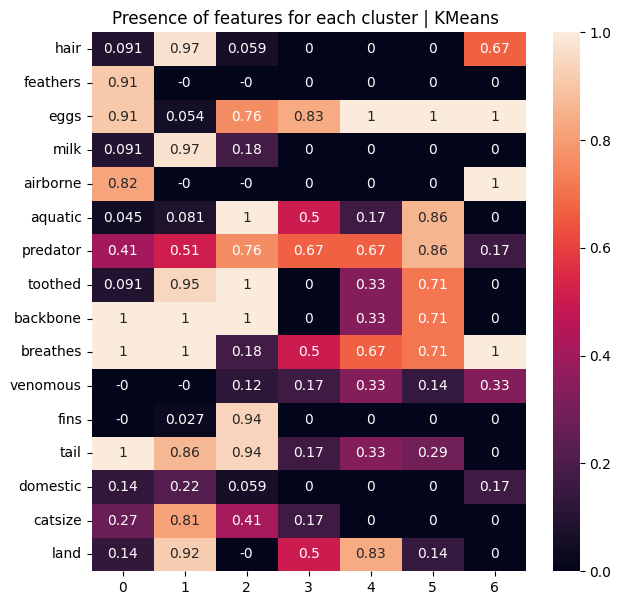

In [36]:
plot_chars_heatmap(np.round(centroids_clusters.drop(["label_cluster", "legs"], axis = 1), 6).T, 
                   "Presence of features for each cluster | KMeans ")

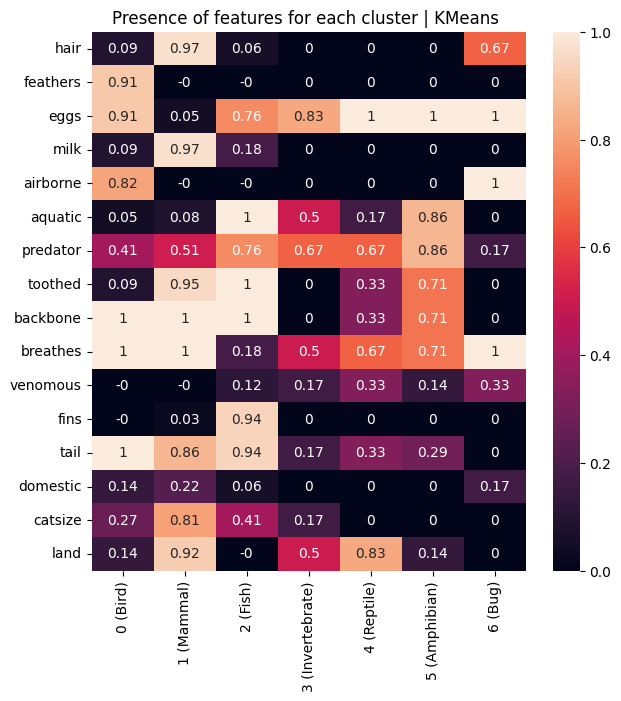

In [38]:
plot_chars_heatmap(np.round(gb_clusters.T, 2), 
                   "Presence of features for each cluster | KMeans ")

In [39]:
metrics_results, cc = classification_metrics(yhat, centroids_clusters,assignment)

# Saving data for Streamlit demo

# classification_metrics(yhat, assignment).to_pickle("../data/kmeans_result_metrics.pkl")
# cc.to_pickle("../data/description_clusters/kmeans_descr.pkl")

In [40]:
metrics_results

,class_name,Accuracy,Precision,Specificity,Recall,F1
0,Bird,0.980198,0.909091,0.975309,1.000000,0.952381
2,Fish,0.960396,0.764706,0.954545,1.000000,0.866667
1,Mammal,0.940594,0.972973,0.983333,0.878049,0.923077
6,Bug,0.980198,1.000000,1.000000,0.750000,0.857143
5,Amphibian,0.970297,0.571429,0.969072,1.000000,0.727273
4,Reptile,0.930693,0.333333,0.958333,0.400000,0.363636
3,Invertebrate,0.920792,0.666667,0.978022,0.400000,0.500000


## DBSCAN

- DBSCAN is a density based model. It doesn't search for a centroid, so we'll need to compute it afterwards manually. 
- We need to initialize it first. We'll try to search for a combination of eps and min_samples (hyperparameters) that fits the k = 7 number of clusters.

In [50]:
# Search for an initial eps and min_samples hyperparameters

hyperp_search_tuples = []
for ep_val in range(10):
    for ms_val in range(30):
        dbsc = DBSCAN(eps = ep_val+1,min_samples = ms_val+1).fit_predict(X)
        unique_clusters = len(set(dbsc))
        hyperp_search_tuples.append((ep_val+1,ms_val+1,unique_clusters))

result_hyperp_search = pd.DataFrame(hyperp_search_tuples, columns = ['eps', "min_samples", "unique_clusters"])

eps, min_samples, unique_clusters = list(result_hyperp_search[result_hyperp_search['unique_clusters'] == 7].iloc[0])
print(eps,min_samples)

dbsc = DBSCAN(eps = eps,min_samples = min_samples)
y_pred_dbsc = dbsc.fit_predict(X)

1 4


In [51]:
yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters = result_pipeline(y_pred_dbsc,
                                                                                           zm,
                                                                                           X, 
                                                                                           labels, 
                                                                                           dict_class_types, 
                                                                                           class_label, create_centroids=[True, None])

In [ ]:
assignment

{3: '3 (Amphibian)',
 1: '1 (Fish)',
 2: '2 (Bird)',
 4: '4 (Bug)',
 0: '0 (Mammal)',
 -1: '-1 (Reptile)',
 5: '5 (Invertebrate)'}

- Comparing it with KMeans, DBSCAN it is more "certain" about some features for various classes.
- For example, for Fish, we have an average presence of 100% for the feature "fins". What this means is that, everything that was labeled as a Fish has fins.
- The same happens with the feature "milk" for Mammals, and "airborne" for Birds and Bugs.

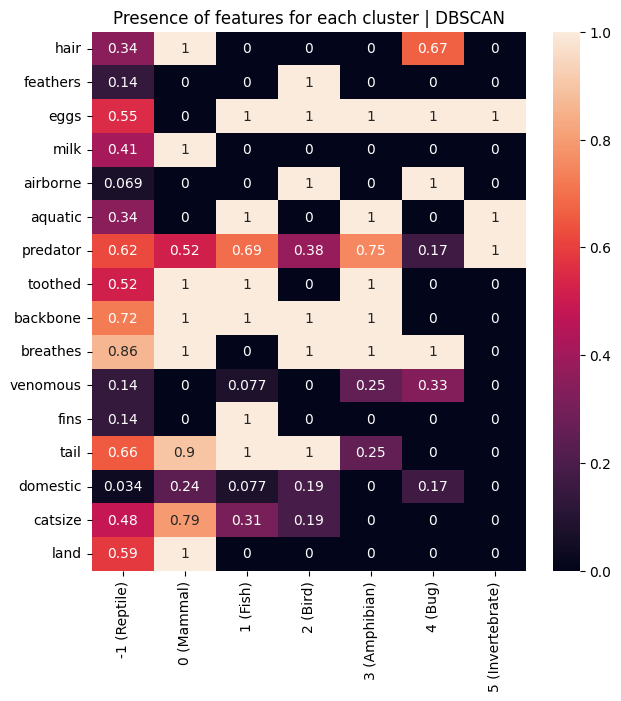

In [53]:
plot_chars_heatmap(gb_clusters.T, 
                   "Presence of features for each cluster | DBSCAN")

In [54]:
metrics_result, cc = classification_metrics(yhat, centroids_clusters ,assignment)

# Saving data for Streamlit demo

# classification_metrics(yhat, assignment).to_pickle("../data/dbscan_result_metrics.pkl")
# cc.to_pickle("../data/description_clusters/dbscan_descr.pkl")

In [55]:
metrics_result

,class_name,Accuracy,Precision,Specificity,Recall,F1
3,Amphibian,1.000000,1.000000,1.00,1.000000,1.000000
1,Fish,1.000000,1.000000,1.00,1.000000,1.000000
2,Bird,0.960396,1.000000,1.00,0.800000,0.888889
4,Bug,0.980198,1.000000,1.00,0.750000,0.857143
0,Mammal,0.881188,1.000000,1.00,0.707317,0.828571
-1,Reptile,0.762376,0.172414,0.75,1.000000,0.294118
5,Invertebrate,0.940594,1.000000,1.00,0.400000,0.571429


## KMedoids

- The KMedoids algorithm works pretty much the same as KMeans, but instead of looking for a centroid that minimize the distance between points it assigns actual data points as centroids.
- It is better for interpretability than KMeans, but could be slower.

In [56]:
km = kmedoids.KMedoids(7, method = "pam",random_state=42)
y_pred_km = km.fit_predict(euclidean_distances(X))

In [57]:
yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters = result_pipeline(y_pred_km,
                                                                                           zm,
                                                                                           X, 
                                                                                           labels, 
                                                                                           dict_class_types, 
                                                                                           class_label, create_centroids=[True, None])

In [ ]:
assignment

{1: '1 (Bird)',
 2: '2 (Amphibian)',
 5: '5 (Bug)',
 3: '3 (Fish)',
 4: '4 (Mammal)',
 0: '0 (Reptile)',
 6: '6 (Invertebrate)'}

- We get similar results as KMeans, but with a mixed level of presence between features and classes.

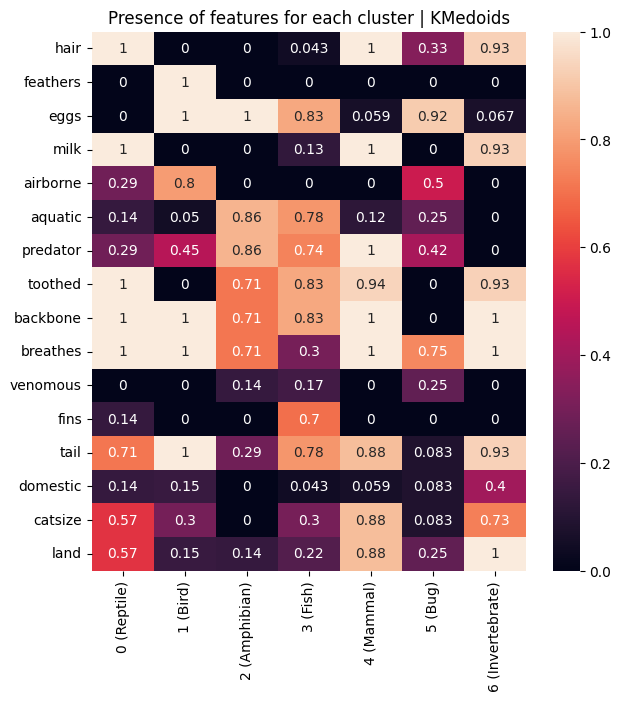

In [61]:
plot_chars_heatmap(gb_clusters.T,   
                   "Presence of features for each cluster | KMedoids")

In [62]:
metrics_result, cc = classification_metrics(yhat, centroids_clusters,assignment)

# Saving data for Streamlit demo

# classification_metrics(yhat, assignment).to_pickle("../data/kmediods_result_metrics.pkl")
# cc.to_pickle("../data/description_clusters/kmediods_descr.pkl")

In [63]:
metrics_result

,class_name,Accuracy,Precision,Specificity,Recall,F1
1,Bird,1.000000,1.000000,1.000000,1.000000,1.000000
2,Amphibian,0.970297,0.571429,0.969072,1.000000,0.727273
5,Bug,0.960396,0.666667,0.956989,1.000000,0.800000
3,Fish,0.900990,0.565217,0.886364,1.000000,0.722222
4,Mammal,0.762376,1.000000,1.000000,0.414634,0.586207
0,Reptile,0.881188,0.000000,0.927083,0.000000,0.000000
6,Invertebrate,0.752475,0.000000,0.835165,0.000000,0.000000


## KMeans init

- Virtually the same as KMeans, but we ask the question: what if we can infer some of the classes?
- We have knowledge that we can use for a better prediction. It is known that Mammals drink milk, birds fly and have feathers, fish are aquatic and have fins.
- So, we could try to initialize KMeans with a known set of centroids.

In [64]:
list_zeroes = [0]*len(X.columns)

# mammals drink milk and have hair
mammals = list_zeroes.copy()
mammals[list(X.columns).index("milk")] = 1
mammals[list(X.columns).index("hair")] = 1
mammals[list(X.columns).index("backbone")] = 1


# birds have feathers
birds = list_zeroes.copy()
birds[list(X.columns).index("feathers")] = 1
birds[list(X.columns).index("eggs")] = 1
birds[list(X.columns).index("airborne")] = 1

# reptiles
reptiles = list_zeroes.copy()
reptiles[list(X.columns).index("toothed")] = 1
reptiles[list(X.columns).index("eggs")] = 1

# fish 
fish = list_zeroes.copy()
fish[list(X.columns).index("fins")] = 1
fish[list(X.columns).index("aquatic")] = 1
fish[list(X.columns).index("backbone")] = 1

# amphibians live in water to lay eggs, breathe and have backbone
amph = list_zeroes.copy()
amph[list(X.columns).index("aquatic")] = 1
amph[list(X.columns).index("eggs")] = 1
amph[list(X.columns).index("breathes")] = 1
amph[list(X.columns).index("backbone")] = 1

# bugs have 6 eggs (or more) and lay eggs
bugs = list_zeroes.copy()
bugs[list(X.columns).index("legs")] = 6
bugs[list(X.columns).index("eggs")] = 1

# invt do not have backbones
inver = list_zeroes.copy()
inver[list(X.columns).index("backbone")] = 0


init_kmeans = [mammals, birds, reptiles, fish, amph, bugs, inver]


In [65]:
# From the project description, we know that we have 7 clusters.

k = 7
kmeans = KMeans(n_clusters = k, random_state=42, init= init_kmeans)
y_pred_kmeans_init = kmeans.fit_predict(X)

In [66]:
yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters = result_pipeline(y_pred_kmeans_init,
                                                                                           zm,
                                                                                           X, 
                                                                                           labels, 
                                                                                           dict_class_types, 
                                                                                           class_label, create_centroids=[True, None])

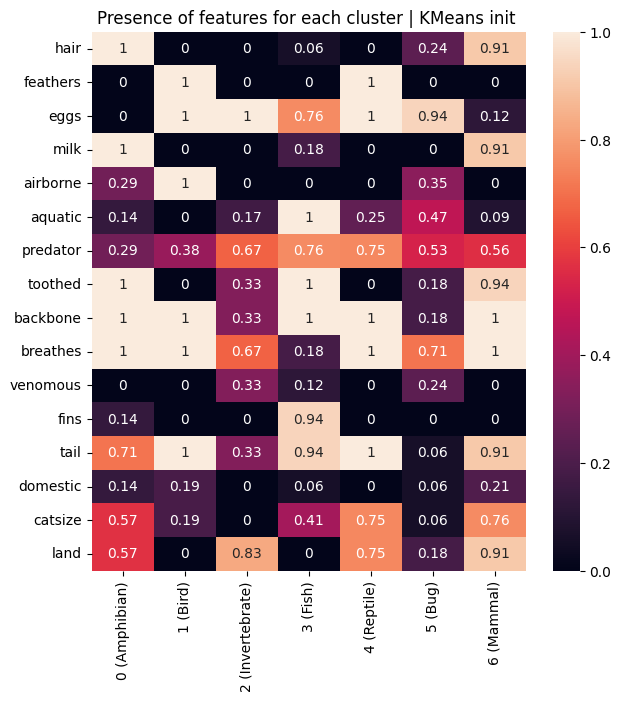

In [74]:
plot_chars_heatmap(np.round(gb_clusters.T, 2), 
                   "Presence of features for each cluster | KMeans init ")

In [73]:
assignment

{1: 'Bird',
 3: 'Fish',
 6: 'Mammal',
 5: 'Bug',
 4: 'Reptile',
 0: 'Amphibian',
 2: 'Invertebrate'}

In [71]:
metrics_result, cc = classification_metrics(yhat, centroids_clusters, assignment)

# Saving data for Streamlit demo

# classification_metrics(yhat, assignment).to_pickle("../data/kmeans_w_init_result_metrics.pkl")
# cc.to_pickle("../data/description_clusters/kmeans_w_init_descr.pkl")

In [72]:
metrics_result

,class_name,Accuracy,Precision,Specificity,Recall,F1
1,Bird,0.960396,1.000000,1.000000,0.800000,0.888889
3,Fish,0.960396,0.764706,0.954545,1.000000,0.866667
6,Mammal,0.871287,0.911765,0.950000,0.756098,0.826667
5,Bug,0.910891,0.470588,0.903226,1.000000,0.640000
4,Reptile,0.910891,0.000000,0.958333,0.000000,0.000000
0,Amphibian,0.891089,0.000000,0.927835,0.000000,0.000000
2,Invertebrate,0.920792,0.666667,0.978022,0.400000,0.500000


## Aglomerative Clustering

- Merges and splits clusters in search of local optimals in each step.
- Doesn't have a centroid so, again, we'll need to compute it manually.
- A good thing is that we can pass directly the number of clusters we want.

In [79]:
agclu = AgglomerativeClustering(n_clusters= k)
y_pred_agclu = agclu.fit_predict(X)

In [80]:
yhat, comp_table, dmatrix, gb_clusters, assignment, assignment_new_label, centroids_clusters = result_pipeline(y_pred_agclu,
                                                                                           zm,
                                                                                           X, 
                                                                                           labels, 
                                                                                           dict_class_types, 
                                                                                           class_label, create_centroids=[True, None])

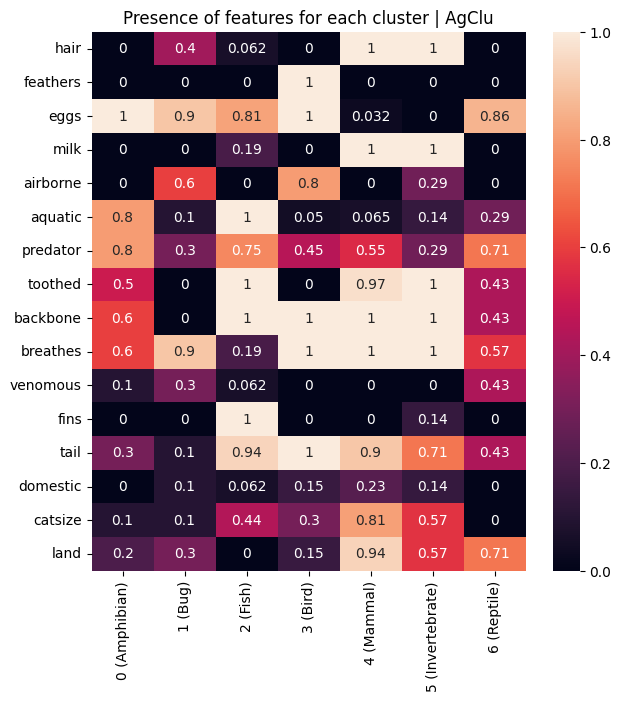

In [81]:
plot_chars_heatmap(gb_clusters.T, 
                   "Presence of features for each cluster | AgClu")

In [82]:
metrics_result, cc = classification_metrics(yhat, centroids_clusters,assignment)

# Saving data for Streamlit demo

# metrics_result.to_pickle("../data/agclu_result_metrics.pkl")
# cc.to_pickle("../data/description_clusters/agclu_descr.pkl")

In [83]:
metrics_result

,class_name,Accuracy,Precision,Specificity,Recall,F1
3,Bird,1.000000,1.000000,1.000000,1.000000,1.000000
2,Fish,0.970297,0.812500,0.965909,1.000000,0.896552
1,Bug,0.980198,0.800000,0.978495,1.000000,0.888889
4,Mammal,0.900990,1.000000,1.000000,0.756098,0.861111
0,Amphibian,0.940594,0.400000,0.938144,1.000000,0.571429
6,Reptile,0.940594,0.428571,0.958333,0.600000,0.500000
5,Invertebrate,0.831683,0.000000,0.923077,0.000000,0.000000
